# Chapter 15: Monte Carlo Simulations of Thermal Systems

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

## 15.1 Introduction

Apply Monte Carlo simulations to thermal physics and statistical mechanics.

## 15.2 The Microcanonical Ensemble

Consider a isolated system of

- number of particles $N$
- volume $V$
- total energy $E$

The values $N$, $V$, and $E$ specify the *macrostate* of the system.

There are many ways or *configurations* in which the macrostate $(E, V, N)$ can be realized.  

Any particular configuration or *microstate* is accessible if its properties are the same as the given macrostate.

- - -
### Example: spin 1/2 paramagnet system

- one-dimesional system of $N$ non-interacing spins on a lattice
- each spin can be either **up** or **down**, $\pm \mu_i = \mu s_i$ where $s_i = \pm 1$
- external magnetic field $\bf B$
- total energy for the system is $E = -\mu B \sum_i s_i$

A particular microstate is specified by the set of spins $\{ s_1, s_2, \ldots, s_N \}$

The macrostate is specified by $E$ and $N$

See Table 15.1
- - -

At equilibrium, there is no reason to prefer one microstate over another.  Each microstate is *equally probable*.

Suppose there are $\Omega$ accesible microstates. The probability $P_s$ of finding the system in a particular microstate is

$$ P_s = \begin{cases}
1/\Omega, &\mbox{if $s$ is accessible} \\
0, &\mbox{otherwise.}
\end{cases} $$


#### Averages of physical quantities

To compute an average of physical quantity $A$ in a lab experiment, the quantity of interest if measured over a time interval sufficiently long to sample a large number of its accessible microstates.  $P_s$ can be interpreted as the fraction of times that a system is in a given microstate.

Alternatively, we can imagine an *ensemble* of systmes that have the same macrostate but different microstates.  Now $P_s$ is the probability that a system in the ensemble is in microstate $s$.  If $A$ has the value $A_s$ in microstate $s$ then the ensemble averae of $A$ is

$$ \langle A \rangle = \sum_{s=1}^{\Omega} A_s P_s$$

The ensemble of systems for a given $E$, $N$, $V$ is called a *microcanoncial* ensemble.  

The big idea of Monte Carlo methods is that we don't see to model the actual dynamics of going between microstates.

## 15.3 The Demon Algorithm

In a dynamical simulation, we can compute the time-averaged valued of physical quanties of interest.  But this requires integrating the equations of motion for the system. *e.g.* particles bouncing around in a closed box.
- requires equations of motion
- lots of computation to simulate the dynamics

What if no equation of motion is available? We may imagine explicitly listing all of the accessible microstates and calculating the ensemble average directly (see Table 15.1).
- for real systems, $\Omega$ can be incredibly large

A Monte Carlo approach would be to make a random sample of all possible microstates and estimate the ensemble average.
- Naive approach for spin 1/2 paramagnetic example: fix $N$ and random flip each each spin up or down
- Retain microstate only if it has the desired total energy, otherwise, discard
- Very inefficient: most configurations would have to be discarded.

An efficient Monte Carlo procedure for simulating systems at a given energy:
- add an extra degree of freedom to the original macroscopic system of interest (just one more variable)
- historicaly, this extra degrgee of freedom is called a *demon*
- the demon transfers energy as it attempts to change the dynamical variables of the system
- if the change lowers the energy of the system, the excess energy goes to the demon
- if the change increases the energy of the system, the demon gives the extra energy required
- the demon cannot have negative energy


- - -
#### Example: Ideal gas
- $N$ noninteracting particles of mass $m$ (an ideal gas).
- total energy is $E = \sum_i m v_i^2/2$ where $v_i$ is the velocity of particle $i$
- - -

### Demon Algorithm

1. Choose a particle at random and make a trial change its coordinates.
2. Compute $\Delta E$, the change in the energgy of the system due to the change.
3. If $\Delta E \le 0$, the system gives the amount $| \Delta E|$ to the demon, that is, $E_d = E_d - \Delta E$, and the trial configuration is accepted.
4. If $\Delta E \gt 0$ and the demon has sufficient energgy for this change ($E_d \ge \Delta E)$, then the demoon gives the necessary energy to the system, that is, $E_d = E_d - \Delta E$, and the trial configguration is accepted. Otherwise, the trial confiuration is rejected and the configuration is not changed.

Repeat these steps until a representative sample of states is obtained.  Eventually the demon and the system will a agree on average energy for each.

The total energy of the system plus the demon remains constant.

Since the demon in only one degree of freedome, the energy fluctuations of the system will be of order $1/N$, (which is very small for $N \gg 1$).

- - -
#### Example: One-dimensional Ideal gas
- $N$ noninteracting particles of mass $m$ (an ideal gas).
- total energy is $E = \sum_i m v_i^2/2$ where $v_i$ is the velocity of particle $i$
- positions do change but are not needed for calculating energy since particles to not interact
- - -

Define the number of particles

In [240]:
N = 1000

Select a system energy

In [241]:
systemEnergy = 40

We can start the system in any configuration which is consistent with the total desired energy; assume initial that all particles have the same velocity.

Initial velocity of particles

In [242]:
v0 = np.sqrt(2 * systemEnergy / N)

Array to hold the particle velocities initialized to the same initial velocity.

In [243]:
v = np.ones(N) * v0

Maximum velocity change by the demon in any one potential change of microstate

In [244]:
delta = 4

The demon starts out with zero energy.

In [245]:
demonEnergy = 0

The parameter `mcs` controls the number of Monte Carlo steps per particle. On average, the demon will attempt to changge the velocity of each particle once per Monte Carlo step per particle.  We refer the number of Monte Carlo steps per particle as the "time" even thought this is not a physical time.

In [246]:
mcs = 0

Variables to track progress of simulation

In [247]:
systemEnergyAccumulator = 0
systemEnergyHistory = []
demonEnergyAccumulator = 0
demonEnergyHistory = []
acceptedMoves = 0

In [252]:
def showSimulationInfo():
    global delta, N, v
    global systemEnergy, systemEnergyAccumulator
    global systemEnergyHistory
    global demonEnergy, demonEnergyAccumulator
    global demonEnergyHistory
    global mcs, acceptedMoves
    
    print(f'mcs = {mcs}')
    print(f'acceptedMoves = {acceptedMoves}')
    print(f'N = {N}')
    print(f'delta = {delta}')
    print(f'systemEnergy = {systemEnergy:.2f}')
    print(f'systemEnergyAccumulator = {systemEnergyAccumulator:.2f}')
    print(f'demonEnergy = {demonEnergy:.3f}')
    print(f'demonEnergyAccumulator = {demonEnergyAccumulator:.2f}')
    print(f'delta = {delta}')
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.hist(v, bins=20)
    plt.xlabel('v')
    plt.ylabel('number of particles')
    
    plt.subplot(2,1,2)
    plt.plot(systemEnergyHistory, label='$E$')
    plt.plot(demonEnergyHistory, label='$E_d$')
    plt.legend()
    plt.xlabel('mcs')

mcs = 0
acceptedMoves = 0
N = 1000
delta = 4
systemEnergy = 40.00
systemEnergyAccumulator = 0.00
demonEnergy = 0.000
demonEnergyAccumulator = 0.00
delta = 4


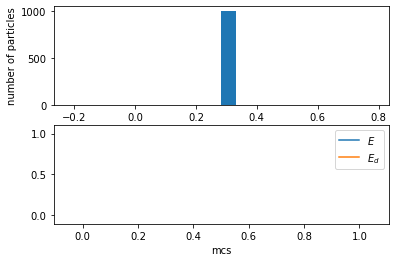

In [253]:
showSimulationInfo()

In [272]:
def doOneMCStep():
    global delta, N, v
    global demonEnergy, demonEnergyAccumulator
    global demonEnergyHistory
    global systemEnergy, systemEnergyAccumulator
    global systemEnergyHistory
    global mcs, acceptedMoves
    
    for j in range(N):
        # choose a particle at random
        particleIndex = np.random.randint(N)
        
        # random change in velocity
        dv = (2*np.random.rand() - 1)*delta
        
        trialVelocity = v[j] + dv
        dE = 0.5*(trialVelocity**2 - v[particleIndex]**2)
        
        if dE < demonEnergy:
            v[particleIndex] = trialVelocity
            acceptedMoves += 1
            systemEnergy += dE
            demonEnergy -= dE
        
        systemEnergyAccumulator += systemEnergy
        demonEnergyAccumulator += demonEnergy
        
    systemEnergyHistory.append(systemEnergy)
    demonEnergyHistory.append(demonEnergy)
        
    #increment Monte Carlo steps per particle ("time")
    mcs += 1

mcs = 2
acceptedMoves = 213
N = 1000
delta = 4
systemEnergy = 39.99
systemEnergyAccumulator = 79853.58
demonEnergy = 0.008
demonEnergyAccumulator = 146.42
delta = 4


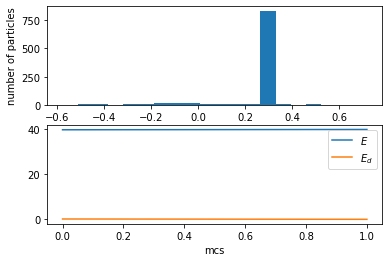

In [276]:
doOneMCStep()
showSimulationInfo()

In [299]:
def initSimulation(N0 = 100, E=40):
    global delta, N, v
    global systemEnergy
    global demonEnergy
    
    N = N0
    systemEnergy = E
    demonEnergy = 0
    
    v0 = np.sqrt(2 * systemEnergy / N)
    v = np.ones(N) * v0
    delta = 4
    
    resetSimulation()
    
def resetSimulation():
    global systemEnergyAccumulator
    global systemEnergyHistory
    global demonEnergyAccumulator
    global demonEnergyHistory
    global mcs, acceptedMoves
    
    mcs = 0
    systemEnergyAccumulator = 0
    systemEnergyHistory = []
    demonEnergyAccumulator = 0
    demonEnergyHistory = []
    acceptedMoves = 0

In [300]:
initSimulation()

mcs = 0
acceptedMoves = 0
N = 100
delta = 4
systemEnergy = 40.00
systemEnergyAccumulator = 0.00
demonEnergy = 0.000
demonEnergyAccumulator = 0.00
delta = 4


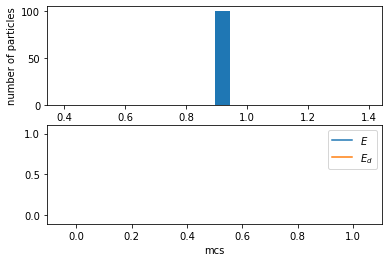

In [301]:
showSimulationInfo()

mcs = 100
acceptedMoves = 3485
N = 100
delta = 4
systemEnergy = 39.49
systemEnergyAccumulator = 392220.36
demonEnergy = 0.514
demonEnergyAccumulator = 7779.64
delta = 4


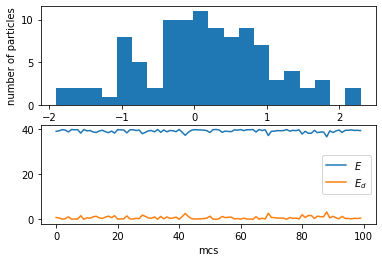

In [302]:
for i in range(100):
    doOneMCStep()
showSimulationInfo()


What is the mean value of particle velocities?

In [228]:
np.mean(v)

-0.004974083963698273

It is unlikely we would ever have all of the particles with the same initial velocity.  We need to let the system evolve until it is equilibrium (average are not changing with time) 

In [267]:
# reset statistics without initializing particles
resetSimulation() 

mcs = 0
acceptedMoves = 0
N = 1000
delta = 4
systemEnergy = 39.92
systemEnergyAccumulator = 0.00
demonEnergy = 0.082
demonEnergyAccumulator = 0.00
delta = 4


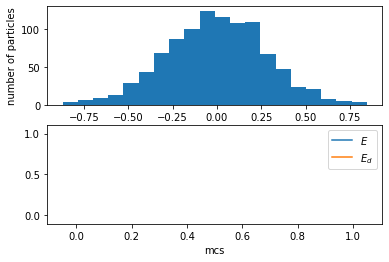

In [268]:
showSimulationInfo()

mcs = 202
acceptedMoves = 22740
N = 1000
delta = 4
systemEnergy = 39.97
systemEnergyAccumulator = 8063828.95
demonEnergy = 0.031
demonEnergyAccumulator = 16171.05
delta = 4


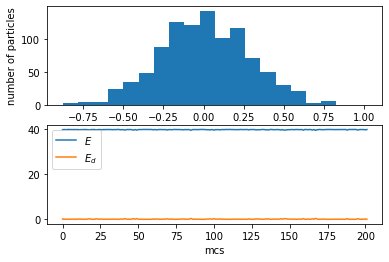

In [281]:
for i in range(100):
    doOneMCStep()
showSimulationInfo()

The time required to reach this equilibrium is called the relaxation time.

What is the mean demon energy, $\langle E_d \rangle $?

In [284]:
np.mean(demonEnergyHistory)

0.07917272902393746

In [285]:
demonEnergyAccumulator / (mcs*N)

0.0800546973558006

What is the mean system energy per particle?

In [289]:
systemEnergyAccumulator / (mcs*N) / N

0.03991994530264498

In [291]:
np.mean(systemEnergyHistory) / N

0.03992082727097584

Compute the mean energy of th demon and the mean system energy per particle for $N=100$ and $E=10$ and $E=20$. How does the mean demon energy relate to the mean system energy per particle?

In [339]:
def computeMeanE(N0=100, E=10):
    initSimulation(N0=N0, E=E)

    # let system come to equilibrium
    for i in range(1000):
        doOneMCStep()

    # compute statistics
    resetSimulation()
    for i in range(100):
        doOneMCStep()

    showSimulationInfo()
    plt.show()

    meanEd = demonEnergyAccumulator / (mcs*N)
    meanE = systemEnergyAccumulator / (mcs*N) / N

    print(f'<Ed> = {meanEd:.4f}')
    print(f'<E> = {meanE:.4f}')
    print()

    row = {'N': N,
           'E': E, 
           '$\langle E_d \rangle$' : meanEd,
           '$\langle E \rangle$' : meanE,}
    return row

mcs = 100
acceptedMoves = 1760
N = 100
delta = 4
systemEnergy = 9.92
systemEnergyAccumulator = 98104.91
demonEnergy = 0.077
demonEnergyAccumulator = 1895.09
delta = 4


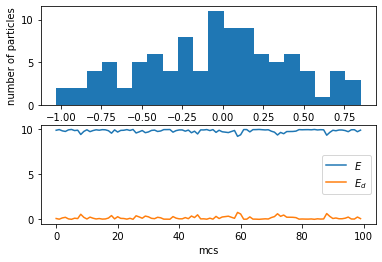

<Ed> = 0.1895
<E> = 0.0981

mcs = 100
acceptedMoves = 2525
N = 100
delta = 4
systemEnergy = 19.78
systemEnergyAccumulator = 195938.18
demonEnergy = 0.219
demonEnergyAccumulator = 4061.82
delta = 4


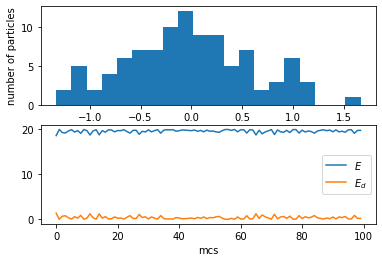

<Ed> = 0.4062
<E> = 0.1959



In [340]:
row1 = computeMeanE(N0 = 100, E=10)
row2 = computeMeanE(N0 = 100, E=20)

In [341]:
pd.DataFrame([row1, row2])

,N,E,$\langle E_d \rangle$,$\langle E \rangle$
0,100,10,0.189509,0.098105
1,100,20,0.406182,0.195938


It shows that $\langle E_d \rangle$ is approximately twice the mean energy per particle.

In our microcanoncial ensemble, the total energy is fixed with no reference to temperature.  Define the kinetic temperature by the relation 

$$ \frac{1}{2} m \langle v^2 \rangle = \frac{1}{2} k T_{\mbox{kinetic}}$$

where $ \frac{1}{2} m \langle v^2 \rangle$ is the mean kinetic energy per particle of the system.

Choose units such that $m$ and the Boltzmann's constant $k$ are unity.

mcs = 100
acceptedMoves = 2462
N = 100
delta = 4
systemEnergy = 19.70
systemEnergyAccumulator = 196178.94
demonEnergy = 0.297
demonEnergyAccumulator = 3821.06
delta = 4


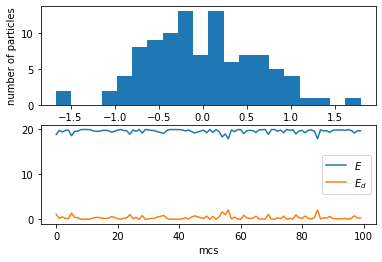

<Ed> = 0.3821
<E> = 0.1962



In [374]:
row = computeMeanE(N0=100, E=20)

In [375]:
m = 1
KE = 0.5 * m * np.mean(v**2)
KE

0.19703158641157184

In [376]:
k = 1
T = 2 / k * KE
T

0.3940631728231437

Compare $T_{\mbox{kinetic}}$ with $\langle E_d \rangle$

In [377]:
meanEd = demonEnergyAccumulator / (mcs*N)
meanEd

0.3821060581245152

How does this result compare to the introductory physics textbook result that the total energy of an ideal gas of $N$ particles in three dimensions is $E = \frac{3}{2} N k T$? (In one dimension, the analgous relation is $E = \frac{1}{2} N k T$)

In [378]:
0.5 * N * k * meanEd

19.10530290622576

## Refactor code to use a class

While `global` variables were useful for initial exploratory programming, they quickly get unwieldy for even moderately size programs.

One approach would be to encapsulate the data and the functions in a single `class`.

In [476]:
class IdealGasSimulation():
    def __init__(self, N, E):
        
        self.N = N
        self.systemEnergy = E
        self.demonEnergy = 0
        
        v0 = np.sqrt(2 * systemEnergy / N)
        self.v =  np.ones(N) * v0
        
        self.delta = 4
        
        self.reset()

    def reset(self):
        
        self.mcs = 0
        self.systemEnergyAccumulator = 0
        self.systemEnergyHistory = []
        self.demonEnergyAccumulator = 0
        self.demonEnergyHistory = []
        self.acceptedMoves = 0
    
    def __str__(self):
        return f'''mcs = {self.mcs}
acceptedMoves = {self.acceptedMoves}
N = {self.N}
delta = {self.delta}
systemEnergy = {self.systemEnergy:.2f}
systemEnergyAccumulator = {self.systemEnergyAccumulator:.2f}
demonEnergy = {self.demonEnergy:.3f}
demonEnergyAccumulator = {self.demonEnergyAccumulator:.2f}
delta = {self.delta}'''
    
    def __repr__(self):
        return self.__str__()
        
    def show(self):
        print(f'mcs = {self.mcs}')
        print(f'acceptedMoves = {self.acceptedMoves}')
        print(f'N = {self.N}')
        print(f'delta = {self.delta}')
        print(f'systemEnergy = {self.systemEnergy:.2f}')
        print(f'systemEnergyAccumulator = {self.systemEnergyAccumulator:.2f}')
        print(f'demonEnergy = {self.demonEnergy:.3f}')
        print(f'demonEnergyAccumulator = {self.demonEnergyAccumulator:.2f}')
        print(f'delta = {self.delta}')

        plt.figure()
        plt.subplot(2,1,1)
        plt.hist(self.v, bins=20)
        plt.xlabel('v')
        plt.ylabel('number of particles')

        plt.subplot(2,1,2)
        plt.plot(self.systemEnergyHistory, label='$E$')
        plt.plot(self.demonEnergyHistory, label='$E_d$')
        plt.legend()
        plt.xlabel('mcs')
    
    def doStep(self):
        
        for j in range(self.N):
            # choose a particle at random
            particleIndex = np.random.randint(self.N)

            # random change in velocity
            dv = (2*np.random.rand() - 1)*self.delta

            trialVelocity = self.v[j] + dv
            dE = 0.5*(trialVelocity**2 - self.v[particleIndex]**2)

            if dE < self.demonEnergy:
                self.v[particleIndex] = trialVelocity
                self.acceptedMoves += 1
                self.systemEnergy += dE
                self.demonEnergy -= dE

            self.systemEnergyAccumulator += self.systemEnergy
            self.demonEnergyAccumulator += self.demonEnergy

        self.systemEnergyHistory.append(self.systemEnergy)
        self.demonEnergyHistory.append(self.demonEnergy)
        
        #increment Monte Carlo steps per particle ("time")
        self.mcs += 1
    
    def doSteps(self, m=1):
        for i in range(m):
            self.doStep()
            

In [477]:
sim = IdealGasSimulation(N=100, E=40)

In [478]:
sim.doSteps(100)

In [486]:
sim.reset()
sim.doSteps(1000)

mcs = 1000
acceptedMoves = 25325
N = 100
delta = 4
systemEnergy = 39.64
systemEnergyAccumulator = 3960281.49
demonEnergy = 0.365
demonEnergyAccumulator = 39718.51
delta = 4


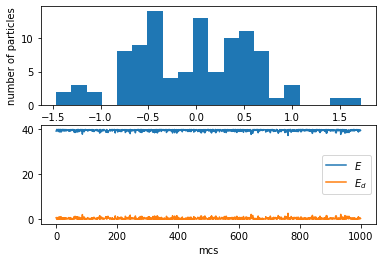

In [487]:
sim.show()

**Problem 15.3** Demon energy distribution

In [490]:
sim.reset()
sim.doSteps(1000)

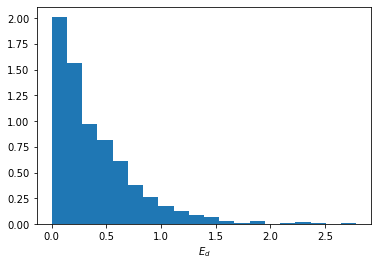

In [492]:
plt.hist(sim.demonEnergyHistory, density=True, bins=20)
plt.xlabel('$E_d$')
plt.show()

In [499]:
hist, bin_edes = np.histogram(sim.demonEnergyHistory, bins=20)